# Proposed Solution - Evaluation Exercise for GSoC 2021
## Deep autoencoders for ATLAS data compression

### Preprocessing Data
Semicolon becomes comma, there was an incongruency in original data

In [1]:
pre_data_path = 'Data/monojet_Zp2000.0_DM_50.0_chan3.csv'
text_file = open(pre_data_path, "r")
text_file = ''.join([i for i in text_file]) \
    .replace(";", ",")

file_to_write = open("Data/clean_data.csv","w")
file_to_write.writelines(text_file)
file_to_write.close()

Forcing the number of columns in order to avoid tokenization errors or either to remove some data

In [2]:
import pandas as pd
import numpy as np 

data_path = 'Data/clean_data.csv'
col_names = ["event ID", "process ID", "event weight", "MET", "METphi", 
             "obj1", "E1", "pt1", "eta1","phi1", "obj2", "E2", "pt2", "eta2", "phi2",
             "obj3", "E3", "pt3", "eta3","phi3", "obj4", "E4", "pt4", "eta4", "phi4",
             "obj5", "E5", "pt5", "eta5","phi5", "obj6", "E6", "pt6", "eta6", "phi6",
             "obj7", "E7", "pt7", "eta7", "phi7", "obj8", "E8", "pt8", "eta8", "phi8", 
             "obj9", "E9", "pt9", "eta9" , "phi9", "obj10", "E10", "pt10", "eta10", "phi10",
             "obj11", "E11", "pt11", "eta11" , "phi11", "obj12", "E13", "pt14", "eta15" , "phi16"]

data = pd.read_csv(data_path,names = col_names, header = None)
data.head()

,event ID,process ID,event weight,MET,METphi,obj1,E1,pt1,eta1,phi1,...,obj11,E11,pt11,eta11,phi11,obj12,E13,pt14,eta15,phi16
0,354,monojet_Zp2000.0_DM_50.0,0.000024,832841.0,-1.22431,b,947383.0,824498.0,-0.523103,1.644210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,354,monojet_Zp2000.0_DM_50.0,0.000024,732115.0,1.17245,j,1069460.0,751597.0,0.858186,-1.842170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,354,monojet_Zp2000.0_DM_50.0,0.000024,1056280.0,-3.06744,j,676000.0,640429.0,0.330450,0.704554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,354,monojet_Zp2000.0_DM_50.0,0.000024,631781.0,1.64181,j,936707.0,616229.0,0.973383,-1.565920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,354,monojet_Zp2000.0_DM_50.0,0.000024,457316.0,-1.87536,j,640313.0,589524.0,0.390749,1.237340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Removing the first 5 columns (are not necessary for our purposes). After that, vertically stacking the other columns by keeping only "j" objects as needed

In [3]:
data = data.iloc[:,5:]
data_arr = []
for i in range(0, data.shape[1], 5):
    data_arr.append(data[data.iloc[:,i] =="j"].iloc[:,i:i+5])


In [4]:
data_final = data_arr[0]
for i in range(1, len(data_arr)):
    data_arr[i].columns = data_arr[0].columns
    data_final = pd.concat([data_final,data_arr[i]], ignore_index = True)    
    
data_final.columns = ["obj", "E", "pt", "eta", "phi"]

In [5]:
data_final.head()

,obj,E,pt,eta,phi
0,j,1069460.0,751597.0,0.858186,-1.842170
1,j,676000.0,640429.0,0.330450,0.704554
2,j,936707.0,616229.0,0.973383,-1.565920
3,j,640313.0,589524.0,0.390749,1.237340
4,j,583373.0,545730.0,0.364057,-1.607320


In [6]:
data_final = data_final.iloc[:,1:]
data_final.head()

,E,pt,eta,phi
0,1069460.0,751597.0,0.858186,-1.842170
1,676000.0,640429.0,0.330450,0.704554
2,936707.0,616229.0,0.973383,-1.565920
3,640313.0,589524.0,0.390749,1.237340
4,583373.0,545730.0,0.364057,-1.607320


### Train / Test Splitting
Technically speaking, before normalization we should separate training data and validation data. We are acting like they are real test data, this basically means that - in principle - it wouldn't be possible to operate a Min Max Scaling effectively because it might happen that a new data point has some feature-value which is larger than the previous maximum value. 

Here we do a regular train / validation set split, I decided to keep the 80/20 ratio since the original notebook has this one. 

In [7]:
# splitting train / test (maybe validation would be more appropriate)
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_final, test_size = 0.2, random_state = 137)

### Normalization 
Data are on completely different scales --> normalization (for each column on its own) will help the convergence of our AE. I've tried different ones, but I think that the most effective is the last, we follow a regular Z-score normalization but given the very large variance for feature E and pt, we try to smooth their distribution by filtering data, mean and var with a logarithm (base 10). 

Moreover I've noted the unnormalize function at the end of the suggested notebook, but I've decided not to use the scaling factors for $\eta$ and $\phi$ since I didn't know how to justify them (there might be some physical meaning?!)

In [8]:
# Min Max Normalization --> values between 0 and 1 
def min_max_normalization(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

## mean Normalization - regular Z-score normalization
def mean_normalization(df):
    result = df.copy()
    for feature_name in df.columns:
        mean_value = df[feature_name].mean()
        std_value = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean_value) / std_value
    return result

## mean log normalization for E and pt, mean normalization for the other 2 variables
def log_mean_normalization(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name in ["E", "pt"]:
            mean_value_log = np.log10(df[feature_name]).mean()
            std_value_log = np.log10(df[feature_name]).std()
            result[feature_name] = (np.log10(df[feature_name]) - mean_value_log) / std_value_log
            
        else: 
            mean_value = df[feature_name].mean()
            std_value = df[feature_name].std()
            result[feature_name] = (df[feature_name] - mean_value) / std_value
    return result

Now we can normalize train and test set separately, since in real applications we are not aware of the training distribution usually and we might expect to have an already trained model. Real time applications need a clear separation in this sense as well. Performances would be greater in the case where we keep information from the training distribution, but it seems like "cheating" in some way (at least for me :) 

In [9]:
train = log_mean_normalization(train)
test = log_mean_normalization(test)

### A quick glance to our data - EDA 

In [10]:
# Just looking at our data
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
              E        pt       eta       phi
17896 -0.231988 -0.309965  0.948744  0.663952
1473   0.495191  0.987216  0.284007  1.227662
12228 -2.249630 -1.478913 -0.029514  0.910512
18165 -0.200442 -1.531026  1.917238 -0.041340
16891 -1.687684 -1.133188 -0.440664 -0.073843


Testing sample:
              E        pt       eta       phi
2172   0.992874  1.514586  0.084634 -1.662320
21009 -1.993622 -1.469281  0.456569  0.760639
2628   0.765624  1.308438  0.065703 -0.024341
11520 -0.533557 -0.101833  0.473345 -1.461723
17678 -0.788562 -0.471830  0.620766  0.457563


The number of entries in the training data: 18128
The number of entries in the validation data: 4533


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. (keeping the same as the original notebook, just changed the name from m to E in order to keep the same one as the Dataset documentation)

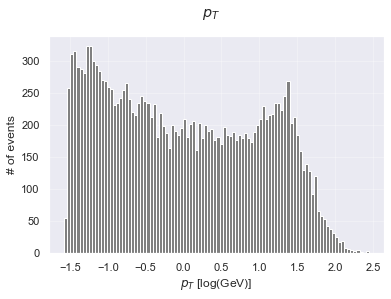

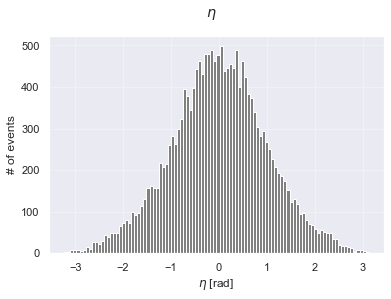

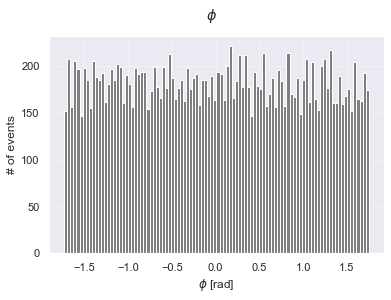

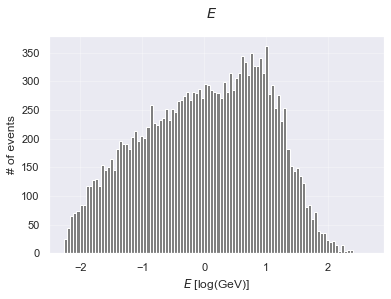

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

unit_list = ['[log(GeV)]', '[rad]', '[rad]', '[log(GeV)]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

branches=["pt","eta","phi","E"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.suptitle(variable_list[kk])
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.grid(alpha = 0.3)
    plt.show()

## Setting up the network


### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [13]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [14]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return m

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [15]:
from fastai.metrics import mse

loss_func =  nn.MSELoss() 

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 0.5

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Alternative 2: Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.0033113110810518267
Learning rate with the steepest gradient: 0.00363078061491251


Text(0.5, 0.98, 'Learning Rate Tuning')

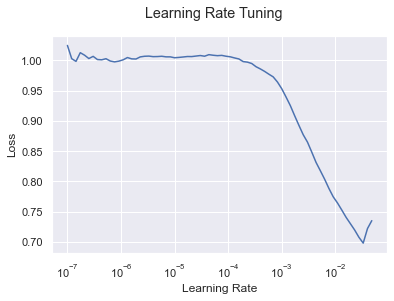

In [16]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)
plt.suptitle("Learning Rate Tuning")

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [17]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.5498286485671997, 0.23703593015670776, '00:00']
[0, 0.5498286485671997, 0.23703593015670776, '00:00']
[1, 0.21081037819385529, 0.10628809034824371, '00:00']
[1, 0.21081037819385529, 0.10628809034824371, '00:00']
[2, 0.11890936642885208, 0.07736750692129135, '00:00']
[2, 0.11890936642885208, 0.07736750692129135, '00:00']
[3, 0.07738956809043884, 0.052804216742515564, '00:00']
[3, 0.07738956809043884, 0.052804216742515564, '00:00']
[4, 0.04638909921050072, 0.019712479785084724, '00:00']
[4, 0.04638909921050072, 0.019712479785084724, '00:00']
[5, 0.015876905992627144, 0.002769959159195423, '00:00']
[5, 0.015876905992627144, 0.002769959159195423, '00:00']
[6, 0.004991821479052305, 0.0013612492475658655, '00:00']
[6, 0.004991821479052305, 0.0013612492475658655, '00:00']
[7, 0.0019894768483936787, 0.0010291339131072164, '00:00']
[7, 0.0019894768483936787, 0.0010291339131072164, '00:00']
[8, 0.001154981437139213, 0.0008849122677929699, '00:00']
[8, 0.001154981437139213, 0.00088491226779

[70, 0.00044939661165699363, 0.0004657093377318233, '00:00']
[70, 0.00044939661165699363, 0.0004657093377318233, '00:00']
[71, 0.0004246253811288625, 0.0004498696653172374, '00:00']
[71, 0.0004246253811288625, 0.0004498696653172374, '00:00']
[72, 0.0004352379764895886, 0.0004087724955752492, '00:00']
[72, 0.0004352379764895886, 0.0004087724955752492, '00:00']
[73, 0.0003432351222727448, 0.00038724642945453525, '00:00']
[73, 0.0003432351222727448, 0.00038724642945453525, '00:00']
[74, 0.0003197621845174581, 0.00045473501086235046, '00:00']
[74, 0.0003197621845174581, 0.00045473501086235046, '00:00']
[75, 0.00031292648054659367, 0.00036145676858723164, '00:00']
[75, 0.00031292648054659367, 0.00036145676858723164, '00:00']
[76, 0.0002925108128692955, 0.0004174825153313577, '00:00']
[76, 0.0002925108128692955, 0.0004174825153313577, '00:00']
[77, 0.00025330198695883155, 0.0003688047581817955, '00:00']
[77, 0.00025330198695883155, 0.0003688047581817955, '00:00']
[78, 0.0002385718107689172, 

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

Text(0, 0.5, 'Loss')

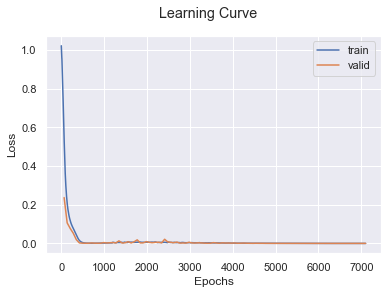

In [18]:
recorder.plot_loss()
plt.suptitle("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [23]:
learn.validate()

(#1) [0.00021759125229436904]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [24]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Make the histograms from the dataset...

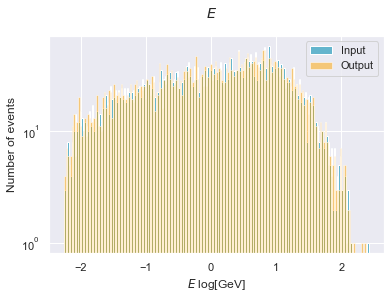

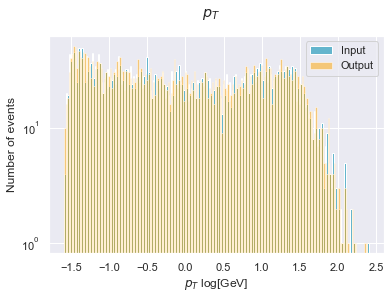

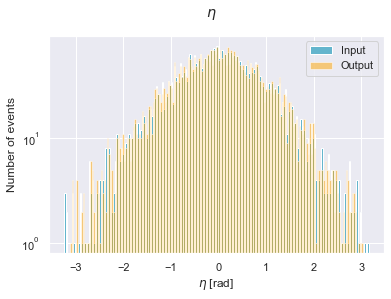

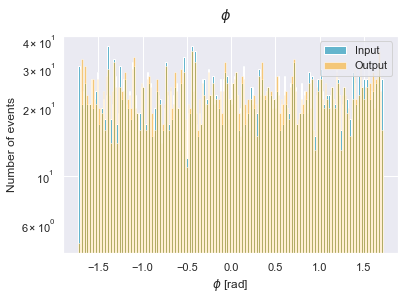

In [25]:
from scipy.stats import wasserstein_distance

plt.close('all')
unit_list = ['log[GeV]','log[GeV]', '[rad]', '[rad]']
variable_list = [ r'$E$',r'$p_T$', r'$\eta$', r'$\phi$']

line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

    
alph = 0.5
n_bins = 200
ws_distances = []
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    #sns.jointplot(x = n_hist_data, y = n_hist_pred, data = bin_edges)
    plt.suptitle(variable_list[kk])
    plt.xlabel(xlabel = variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    plt.yscale('log')
    plt.legend()
    ws_distances.append(wasserstein_distance(n_hist_pred, n_hist_data))
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))

In [27]:
ws_distances

[0.42000000000000015,
 0.4599999999999998,
 0.7499999999999997,
 0.42999999999999994]